In [1]:
import numpy as np
import matplotlib.pyplot as plt
from tqdm.auto import tqdm

In [2]:
import sys
# Don't generate the __pycache__ folder locally
sys.dont_write_bytecode = True 
# Print exception without the buit-in python warning
sys.tracebacklimit = 0

In [3]:
from modules import *

In [4]:
lbl_cmap = random_label_cmap()

In [5]:
import os
os.environ['TF_CPP_MIN_LOG_LEVEL'] = '2'
from stardist.models import StarDist2D
model = StarDist2D.from_pretrained('2D_versatile_fluo')

def predict_mask_from_image_stardist(img_patch):

    """
    Predicts a segmentation mask from an image patch.

    This function takes an image patch and uses a pre-defined model
    to predict the segmentation mask. It silences any print output during the prediction 
    to keep the console clean. The function assumes that the model is already 
    loaded and available in the global scope.

    Args:
    img_patch (numpy array): The image patch for which to predict the segmentation mask.

    Returns:
    numpy array: The predicted segmentation mask, where each pixel's intensity corresponds to a label.
    """

    # Performing the prediction using the pre-defined model
    labels, details = model.predict_instances(img_patch)

    # Returning the predicted segmentation mask
    return labels.astype('uint16')

Found model '2D_versatile_fluo' for 'StarDist2D'.
Loading network weights from 'weights_best.h5'.
Loading thresholds from 'thresholds.json'.
Using default values: prob_thresh=0.479071, nms_thresh=0.3.


In [6]:
window_size = 256
overlap = int(0.5 * window_size)

In [9]:
normalized_img = read_image_as_grayscale_then_MinMax_normalize('image.png')

In [24]:
patches, window_coords = patchify(normalized_img, window_size, overlap)

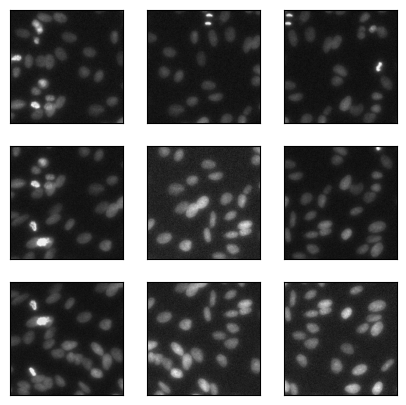

In [25]:
# View patches
num_rows = len(set(y for _, _, _, y in window_coords))
num_cols = len(set(x for x, _, _, _ in window_coords))

fig, axs = plt.subplots(num_rows, num_cols, figsize=(5, 5))

for ax, patch in zip(axs.ravel(), patches):
    ax.imshow(patch, cmap='gray')
    ax.set_xticks([])
    ax.set_yticks([])

# Save the figure
plt.savefig('patches.png', dpi=300, bbox_inches='tight')
plt.show()

In [12]:
predicted_labels = []

for patch in tqdm(patches, desc = 'Predicting on patches', leave = True):

    label = predict_mask_from_image_stardist(patch)

    predicted_labels.append(label)

Predicting on patches:   0%|          | 0/9 [00:00<?, ?it/s]

1/1 [==============================] - 0s 26ms/step


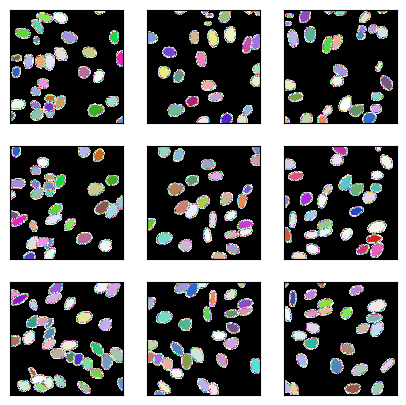

In [21]:
# View patches
num_rows = len(set(y for _, _, _, y in window_coords))
num_cols = len(set(x for x, _, _, _ in window_coords))

fig, axs = plt.subplots(num_rows, num_cols, figsize=(5, 5))

for ax, patch in zip(axs.ravel(), predicted_labels):
    ax.imshow(patch, cmap=lbl_cmap)
    ax.set_xticks([])
    ax.set_yticks([])

# Save the figure
plt.savefig('predictions.png', dpi=300, bbox_inches='tight')
plt.show()

In [16]:
border_cleaned_predicted_labels = []

for patch, patch_coords in zip(predicted_labels, window_coords):
    cleaned_patch = remove_border_labels(patch, patch_coords, normalized_img)
    border_cleaned_predicted_labels.append(cleaned_patch)

In [17]:
region_info_list = compile_label_info(np.array(border_cleaned_predicted_labels), window_coords)

In [18]:
# First, extract the bounding boxes from each region in the region_info_list
# This creates an array of bounding boxes where each box is defined by [x_min, y_min, x_max, y_max]
boxes = np.array([region['global_bbox'] for region in region_info_list])

# Apply the Non-Maximum Suppression (NMS) function to these boxes.
# NMS will analyze these bounding boxes and return the indices of boxes that should be kept
# based on the overlap threshold of 0.5. Boxes that overlap more than this threshold with a larger box
# will be filtered out.
nms_indices = non_maximum_suppression(boxes, overlapThresh=0.5)

# Using the indices obtained from NMS, construct the final list of regions.
# This list will only include regions whose bounding boxes were selected by the NMS process,
# effectively filtering out regions with significantly overlapping bounding boxes.
nms_region_info_list = [region_info_list[i] for i in nms_indices]

# final_region_info_list now contains the refined list of regions after applying NMS.
# These are the regions that are considered significant based on their size and the lack of substantial
# overlap with larger regions.

In [19]:
canvas = place_labels_on_canvas(normalized_img, nms_region_info_list)

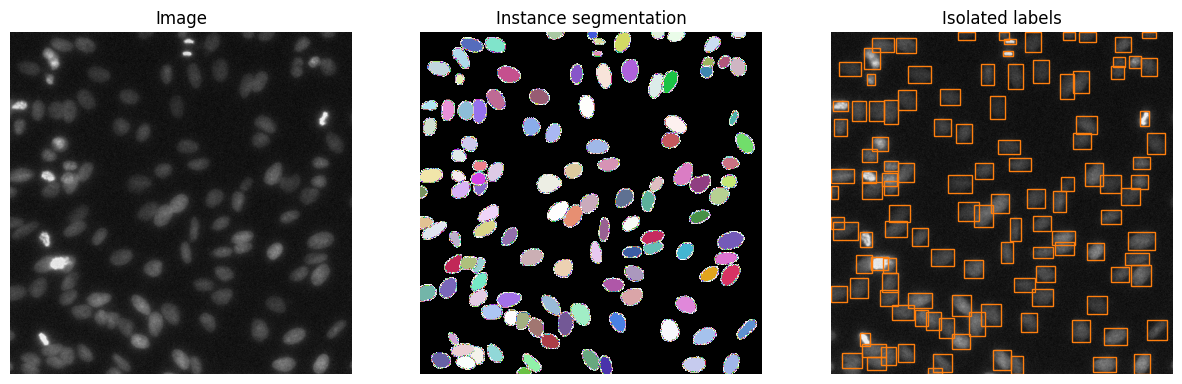

In [26]:
import matplotlib.patches as patches

# Create a figure with three subplots
fig, (ax1, ax2, ax3) = plt.subplots(1, 3, figsize=(15, 5))

# First subplot: Display normalized_img
ax1.imshow(normalized_img, cmap='gray')
ax1.set_title('Image')
ax1.axis('off')

# Second subplot: Display smoothed_canvas
ax2.imshow(canvas, cmap=lbl_cmap, alpha=1)
ax2.set_title('Instance segmentation')
ax2.axis('off')

# Third subplot: Display normalized_img with bounding boxes (after postprocessing)
for region in nms_region_info_list:
    # Extract the bounding box coordinates
    x_min, y_min, x_max, y_max = region['global_bbox']

    # Create a red rectangle patch with a thinner border
    rect = patches.Rectangle((x_min, y_min), x_max - x_min, y_max - y_min, 
                             linewidth=1, edgecolor='tab:orange', facecolor='none')

    # Add the rectangle to the third subplot
    ax3.add_patch(rect)

ax3.imshow(normalized_img, cmap='gray', alpha=1)
ax3.set_title('Isolated labels')
ax3.axis('off')

# Show the result
plt.savefig('result.png', dpi=300, bbox_inches='tight')
plt.show()